In [1]:
import numpy as np
from utils.lattice_utils import plot_lattice
import os
from utils.mat_utils import frac_to_cart_coords, get_pbc_cutoff_graphs, lattice_params_to_matrix_torch
import torch


In [120]:
def post_process_9(input_coords,alpha=1):
    #input_coords shape: 9*3
    lattice = np.random.random(12)
    loss = cal_lattice_loss(lattice,input_coords)
    for _ in range(2000):
        #step = np.random.random(12) * 0.1
        step = np.zeros(12)
        index = np.random.randint(0,12)
        step[index] = np.random.random() * 0.1
        temp_loss = cal_lattice_loss(lattice+step,input_coords)
        #print(temp_loss-loss)
        if temp_loss < loss:
            #print(temp_loss)
            lattice += step
            loss = temp_loss
    return alpha*get_coords_from_lattice(lattice)+(1-alpha)*input_coords,get_connection_9()

def cal_lattice_loss(hypothesis_lattice,input_coords):
    #hypo_lattice: shape 12, (center coord, axis1 vector, axis2 vector, axis3 vector)
    hypo_coords = get_coords_from_lattice(hypothesis_lattice)
    index_mask = np.ones(9)
    loss = 0
    for i in range(9):
        temp_loss = np.inf
        for j in range(9):
            if index_mask[j] > 0:
                if np.linalg.norm(hypo_coords[i]-input_coords[j]) < temp_loss:
                    #temp_loss = np.sum((hypo_coords[i]-input_coords[j])**2)
                    #temp_loss = 1.0/np.linalg.norm(hypo_coords[i]-input_coords[j])
                    temp_loss = np.linalg.norm(hypo_coords[i]-input_coords[j])
                    temp_index = j
        index_mask[temp_index] = 0
        loss += temp_loss
    
    return 0.5*loss + 1/sin_vec(hypothesis_lattice[3:6],hypothesis_lattice[6:9])\
    + 1/sin_vec(hypothesis_lattice[3:6],hypothesis_lattice[9:])\
    + 1/sin_vec(hypothesis_lattice[6:9],hypothesis_lattice[9:])
    #return loss

def get_coords_from_lattice(lattice):
    coords = np.zeros((9,3))
    coords[0] = lattice[:3]
    coords[1] = lattice[:3] + lattice[3:6]/2 + lattice[6:9]/2 + lattice[9:]/2
    coords[2] = lattice[:3] + lattice[3:6]/2 + lattice[6:9]/2 - lattice[9:]/2
    coords[3] = lattice[:3] + lattice[3:6]/2 - lattice[6:9]/2 + lattice[9:]/2
    coords[4] = lattice[:3] + lattice[3:6]/2 - lattice[6:9]/2 - lattice[9:]/2
    coords[5] = lattice[:3] - lattice[3:6]/2 + lattice[6:9]/2 + lattice[9:]/2
    coords[6] = lattice[:3] - lattice[3:6]/2 + lattice[6:9]/2 - lattice[9:]/2
    coords[7] = lattice[:3] - lattice[3:6]/2 - lattice[6:9]/2 + lattice[9:]/2
    coords[8] = lattice[:3] - lattice[3:6]/2 - lattice[6:9]/2 - lattice[9:]/2
    return coords

def get_connection_9():
    connection = []
    edge1 = np.random.random() > 0.
    edge2 = np.random.random() > 0.
    edge3 = np.random.random() > 0.
    edge1 = True
    edge2 = True
    edge3 = True
    if not edge1 and not edge2 and not edge3:
        edge1 = True
    for i in range(8):
        connection.append([4,i])
    if edge1:
        for i in range(4):
            connection.append([i,i+4])
    if edge2:
        connection.append([1,3])
        connection.append([2,4])
        connection.append([5,7])
        connection.append([6,8])
    if edge3:
        connection.append([1,2])
        connection.append([3,4])
        connection.append([5,6])
        connection.append([7,8])
    return connection

def sin_vec(v1,v2):
    return np.sqrt(1-(np.dot(v1,v2)/np.linalg.norm(v1)/np.linalg.norm(v2))**2)

In [3]:
def plot_origin_lattice_from_path(path, name, cutoff=1.0,max_num_neighbors_threshold=3, save_dir=None):
    full_path = os.path.join(path,name)
    lattice_npz = np.load(full_path)
    frac_coords = lattice_npz['origin_frac_coords']
    lengths = lattice_npz['origin_lengths']
    angles = lattice_npz['origin_angles']
    atom_types = lattice_npz['origin_atom_types']
    num_atoms = torch.tensor([atom_types.shape[0]])
    frac_coords, lengths, angles = torch.from_numpy(frac_coords),torch.from_numpy(lengths), torch.from_numpy(angles)
    print(lengths,angles)
    cart_coords = frac_to_cart_coords(frac_coords,lengths,
                                      angles, num_atoms)
    print('num_atoms', num_atoms)
    try:
        # raise Exception
        edge_index = lattice_npz['origin_edge_index']
    except:
        edge_index, _,_ = get_pbc_cutoff_graphs(cart_coords, lengths, angles, num_atoms, cutoff=cutoff, max_num_neighbors_threshold=max_num_neighbors_threshold)
    print('edge_index \n', edge_index)
    plot_lattice(cart_coords,edge_index.T, save_dir=save_dir)

In [126]:
def plot_lattice_from_path(path, name, cutoff=1.0,max_num_neighbors_threshold=3, save_dir=None ):
    full_path = os.path.join(path,name)
    print(full_path)
    lattice_npz = np.load(full_path)
    frac_coords = lattice_npz['frac_coords']
    lengths = lattice_npz['lengths']
    angles = lattice_npz['angles']
    atom_types = lattice_npz['atom_types']
    num_atoms = torch.tensor([atom_types.shape[0]])
    frac_coords, lengths, angles = torch.from_numpy(frac_coords),torch.from_numpy(lengths).unsqueeze(0), torch.from_numpy(angles).unsqueeze(0)
    cart_coords = frac_to_cart_coords(frac_coords,lengths,
                                      angles, num_atoms)
    # cart_coords = frac_coords
    print(lengths, angles)
    print('num_atoms', num_atoms)
    print(frac_coords)
    # try:
    # raise Exception
    edge_index = lattice_npz['edge_index']
    # edge_index = np.array(get_connection_9()).T
    print('edge_index \n', edge_index)

    
    # except:
        # edge_index, _,_ = get_pbc_cutoff_graphs(cart_coords, lengths, angles, num_atoms, cutoff=cutoff, max_num_neighbors_threshold=max_num_neighbors_threshold)
    # try:
    #     print('Properteis: ', lattice_npz['prop_list'])
    #     print('mean:', lattice_npz['prop_list'].mean(), '\nvar:', lattice_npz['prop_list'].std())
    # except:
    #     pass
    plot_lattice(cart_coords,edge_index.T, save_dir=save_dir)




In [143]:
path = 'recon_mat/result_nequip_w_latents_1'
name = 'LatticeStiffness_lattice_9.npz'
plot_lattice_from_path(path, name)

recon_mat/result_nequip_w_latents_1\LatticeStiffness_lattice_9.npz
tensor([[0.6823, 1.5075, 0.7873]]) tensor([[124.8018,  90.7534,  88.1277]])
num_atoms tensor([9])
tensor([[-0.0731,  0.2651,  0.0431],
        [ 0.2456, -0.1639,  0.3020],
        [-0.3114,  0.2478, -0.1342],
        [-0.0071,  0.0178, -0.0048],
        [-0.1895,  0.2181, -0.3290],
        [ 0.0448,  0.2309, -0.1468],
        [ 0.1080, -0.2295,  0.0063],
        [ 0.0067, -0.1669,  0.1116],
        [ 0.0757, -0.2895,  0.1212]])
edge_index 
 [[0 1 2 2 3 0 1 3 4 0 5 1 3 4 5 2 3 4]
 [1 3 3 4 4 5 5 5 5 6 6 7 7 7 7 8 8 8]]


In [36]:
path = 'generated_mat/node_num9_pos2'
name = 'LatticeStiffness_lattice_50.npz'

generated_mat/node_num9_pos2\LatticeStiffness_lattice_50.npz
num_atoms tensor([9])
Properteis:  [ 1.02595035e-02  3.20859207e-03  3.28204012e-03 -4.91347164e-05
 -7.81614799e-05 -3.73979565e-05  1.01773776e-02  3.41012934e-03
  1.69798732e-05  1.08455541e-04 -4.70527448e-05  1.00974794e-02
 -1.57783739e-04  5.29079698e-05  1.03705097e-05  3.25799221e-03
 -6.53935131e-05  6.17350452e-06  3.30868713e-03  5.22094779e-05
  3.28934332e-03]
mean: 0.0023858722 
var: 0.003494158


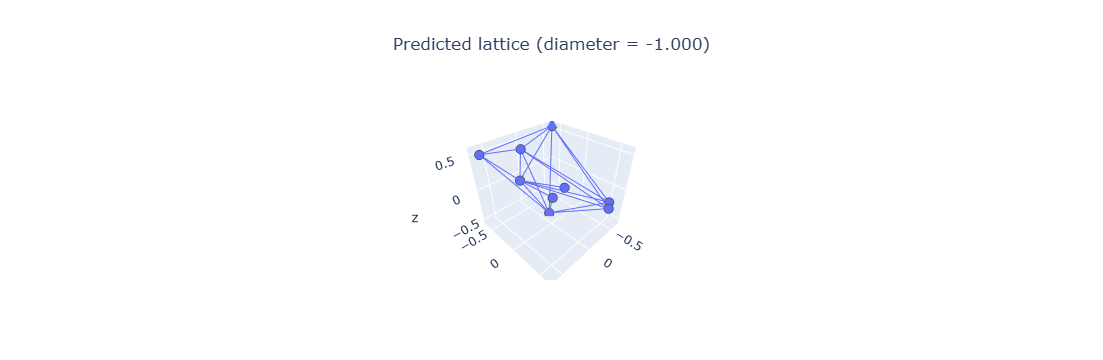

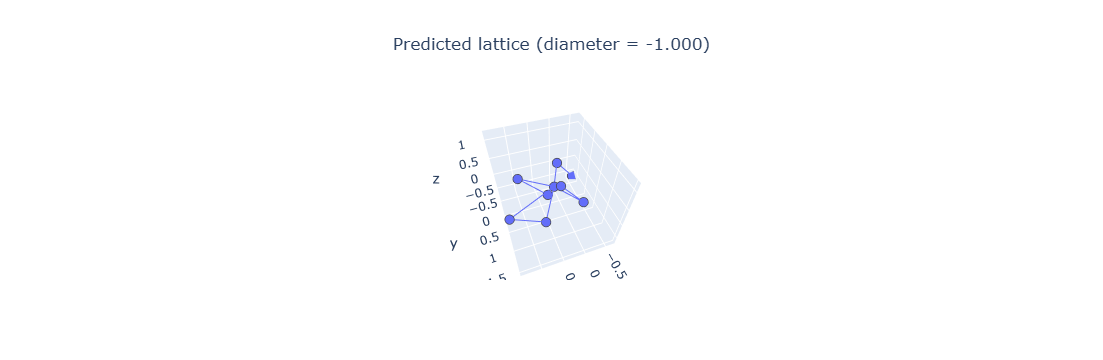

In [38]:
full_path = os.path.join(path,name)
print(full_path)
lattice_npz = np.load(full_path)
frac_coords = lattice_npz['frac_coords']
lengths = lattice_npz['lengths']
angles = lattice_npz['angles']
atom_types = lattice_npz['atom_types']
num_atoms = torch.tensor([atom_types.shape[0]])
frac_coords, lengths, angles = torch.from_numpy(frac_coords),torch.from_numpy(lengths).unsqueeze(0), torch.from_numpy(angles).unsqueeze(0)
cart_coords = frac_to_cart_coords(frac_coords,lengths,
                                  angles, num_atoms)
# cart_coords = frac_coords
print('num_atoms', num_atoms)
try:
    print('Properteis: ', lattice_npz['prop_list'])
    print('mean:', lattice_npz['prop_list'].mean(), '\nvar:', lattice_npz['prop_list'].std())
except:
    pass
try:
        # raise Exception
    edge_index = lattice_npz['edge_index']
except:
    print('Compute PBC edges')
    edge_index, _,_ = get_pbc_cutoff_graphs(cart_coords, lengths, angles, num_atoms, cutoff=cutoff, max_num_neighbors_threshold=max_num_neighbors_threshold)
# print('edge_index \n', edge_index)
plot_lattice(cart_coords, edge_index.T)

lattice_vector = lattice_params_to_matrix_torch(lengths, angles)
a = cart_coords.numpy()
ppa, edges = post_process_9(a,0.9)
edges = np.array(edges)
plot_lattice(ppa,edges)


generated_mat/result_wo_correct\LatticeStiffness_lattice_5.npz
tensor([[2.7610, 1.2396, 3.0868]]) tensor([[ 40.2019,  97.9466, 103.7460]])
num_atoms tensor([9])
edge_index 
 [[0 1 0 0 1 0 1 1 1 1]
 [2 2 3 4 4 5 5 6 7 8]]
Properteis:  [ 1.01230834e-02  3.11406865e-03  3.19573795e-03  1.96485780e-06
  3.18281818e-05 -3.88945919e-05  9.96574014e-03  3.12009640e-03
 -5.81401400e-05  2.20991205e-05 -7.96029344e-05  1.00647835e-02
 -1.03157945e-04  1.53507572e-05 -8.82335007e-05  3.16436077e-03
 -8.67787749e-05  2.12073792e-05  3.24231805e-03  3.07802111e-07
  3.16358474e-03]
mean: 0.0023234156 
var: 0.0034499678


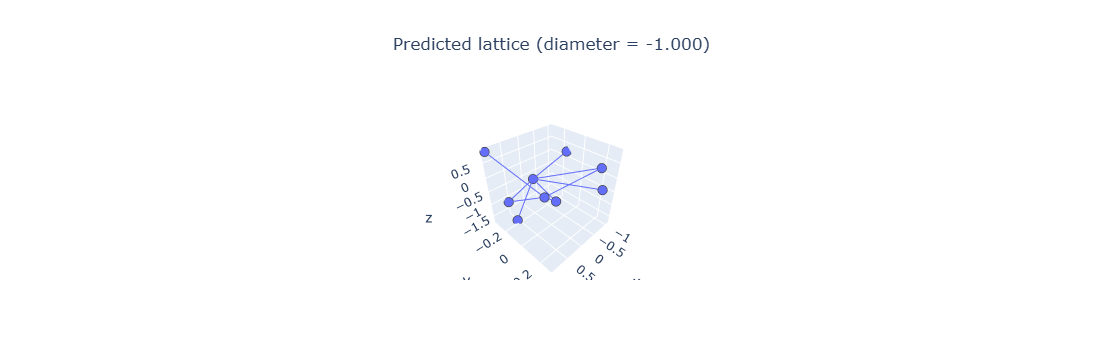

In [97]:
path = 'generated_mat/result_wo_correct'
name = 'LatticeStiffness_lattice_5.npz'
# plot_origin_lattice_from_path(path,name)
plot_lattice_from_path(path, name)

In [96]:
# exceed_num = 0
# for i in range(100):
#     name = 'LatticeStiffness_lattice_{}.npz'.format(i)
#     full_path = os.path.join(path,name)
#     print(full_path)
#     lattice_npz = np.load(full_path)
#     frac_coords = lattice_npz['frac_coords']
#     if np.any(frac_coords < -0.5) or np.any(frac_coords>0.5):
#         exceed_num += 1
# print(exceed_num)

In [108]:
path = 'generated_mat/step50_varProp=0.01_2'
name = 'LatticeStiffness_lattice_3.npz'
plot_lattice_from_path(path, name)

generated_mat/step50_varProp=0.01_2\LatticeStiffness_lattice_3.npz
tensor([[1.5529, 1.5434, 1.5500]]) tensor([[90.6170, 90.6836, 89.1461]])
num_atoms tensor([12])
edge_index 
 tensor([[ 6,  8, 10,  5,  7,  8,  5,  7, 11,  6,  7, 11,  0,  2,  9,  1,  2,  7,
          0,  3,  8,  2,  3,  5,  0,  1,  6,  1,  2,  4,  0,  3, 11,  2,  3, 10],
        [ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  5,
          6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 11]])
Properteis:  [-0.0043955  -0.00286257  0.00374456  0.00170943  0.00566356 -0.00448935
 -0.01409014  0.00767925 -0.00132937  0.00528254 -0.01024122  0.00230721
 -0.00261539  0.00208655 -0.00095623  0.00457684 -0.00131458  0.00750923
  0.00620548  0.00138706 -0.00071043]
mean: 0.00024509183 
var: 0.005455087


In [ ]:
path = 'recon_mat/result_nequip_w_latents_1'
name = 'LatticeStiffness_lattice_2.npz'
plot_lattice_from_path(path, name)

In [89]:
path = 'recon_mat/result_nequip_w_latents/'
name = 'LatticeStiffness_lattice_5.npz'
plot_lattice_from_path(path, name)
plot_origin_lattice_from_path(path, name)

recon_mat/result_nequip_w_latents/LatticeStiffness_lattice_5.npz
tensor([[2.2646, 0.9836, 1.3413]]) tensor([[ 90.0833, 102.3676,  85.2879]])
num_atoms tensor([9])
edge_index 
 [[0 0 0 0 1 1 1 2 2 2 3 3 4 4 4 4 5 5 6 7]
 [1 2 4 5 3 4 6 3 4 7 4 8 5 6 7 8 6 7 8 8]]
Properteis:  -0.00405043
mean: -0.00405043 
var: 0.0


tensor([[2.3680, 0.4856, 1.6928]]) tensor([[ 89.7049, 101.5294,  83.9811]])
num_atoms tensor([9])
edge_index 
 [[0 0 0 0 1 1 1 2 2 2 3 3 4 4 4 4 5 5 6 7]
 [1 2 4 5 3 4 6 3 4 7 4 8 5 6 7 8 6 7 8 8]]
